# Using the Copernicus Seasonal Forecast Tools package to create a hazard object

## Introduction

The [copernicus-seasonal-forecast-tools](https://github.com/DahyannAraya/copernicus-seasonal-forecast-tools) package was developed to manage seasonal forecast data from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu) (CDS) for the [U-CLIMADAPT project](https://www.copernicus-user-uptake.eu/user-uptake/details/responding-to-the-impact-of-climate-change-u-climadapt-488).
It offers comprehensive tools for downloading, processing, computing climate indices, and generating hazard objects based on seasonal forecast datasets, particularly [Seasonal forecast daily and subdaily data on single levels](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview).
The package is tailored to integrate seamlessly with the CLIMADA, supporting climate risk assessment and the development of effective adaptation strategies.

Features:
- Automated download of the high-dimensional seasonal forecasts data via the Copernicus API
- Preprocessing of sub-daily forecast data into daily formats
- Calculation of heat-related climate indices (e.g., heatwave days, tropical nights)
- Conversion of processed indices into CLIMADA hazard objects ready for impact modelling
- Flexible modular architecture to accommodate additional indices or updates to datasets

In this tutorial, you can see a simple example of how to retrieve and process data from Copernicus, calculate a heat-related index, and create a hazard object. For more detailed documentation and advanced examples, please visit the [repository](https://github.com/DahyannAraya/copernicus-seasonal-forecast-tools) or the [documentation](https://copernicus-seasonal-forecast-tools.readthedocs.io/en/latest/?badge=latest).

Prerequisites:

1. CDS account and API key:
   Register at https://cds.climate.copernicus.eu

2. CDS API client installation:
   pip install cdsapi

3. CDS API configuration:
   Create a .cdsapirc file in your home directory with your API key and URL.
   For instructions, visit: https://cds.climate.copernicus.eu/how-to-api#install-the-cds-api-client

4. Dataset Terms and Conditions: After selecting the dataset to download, make
   sure to accept the terms and conditions on the corresponding dataset webpage in the CDS portal before running this notebook. Here, https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download.

For more information, visit the comprehensive [CDS API setup guide](https://copernicus-seasonal-forecast-tools.readthedocs.io/en/latest/cds_api.html), which walks you through each step of the process. Once configured, you'll be ready to explore and analyze seasonal forecast data.

**Note**:
Ensure you have the **necessary permissions** and comply with the CDS data usage policies when using this package. You can view the terms and conditions at https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download. You can find them at the bottom of the download page.

In [1]:
# Import packages

import warnings
import datetime as dt

warnings.filterwarnings("ignore")
from seasonal_forecast_tools import SeasonalForecast, ClimateIndex
from seasonal_forecast_tools.utils.coordinates_utils import bounding_box_from_countries
from seasonal_forecast_tools.utils.time_utils import month_name_to_number

### Set up parameters

To configure the package for working with Copernicus forecast data and converting it into a hazard object for CLIMADA, you will need to define several essential parameters. These settings are crucial as they specify the type of data to be retrieved, the format, the forecast period, and the geographical area of interest. These parameters influence how the forecast data is processed and transformed into a hazard object.

Below, we outline these parameters and use an example for the `Tmax` – Maximum Temperature index to demonstrate the seasonal forecast functionality.

To learn more about what these parameters entail and their significance, please refer to the [documentation on the CDS webpage](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview).

#### Overview of parameters

**index_metric**: Defines the type of index to be calculated. There are currently **12 predefined options** available, including temperature-based indices (`Tmean` – Mean Temperature, `Tmin` – Minimum Temperature, `Tmax` – Maximum Temperature), heat stress indicators (`HIA` – Heat Index Adjusted, `HIS` – Heat Index Simplified, `HUM` – Humidex, `AT` – Apparent Temperature, `WBGT` – Wet Bulb Globe Temperature (Simple)), and extreme event indices (`HW` – Heat Wave, `TR` – Tropical Nights, `TX30` – Hot Days).

  - **Heat Waves ("HW")**:  
    If `index_metric` is set to 'HW' for heat wave calculations, additional parameters can be specified to fine-tune the heat wave detection:

    - **threshold**: Temperature threshold above which days are considered part of a heat wave. Default is 27°C.
    - **min_duration**: Minimum number of consecutive days above the threshold required to define a heat wave event. Default is 3 days.
    - **max_gap**: Maximum allowable gap (in days) between two heat wave events to consider them as one single event. Default is 0 days.

  - **Tropical Nights ("TR")**:  
    If `index_metric` is set to 'TR' for tropical nights, an additional parameter can be specified to set the threshold:

    - **threshold**: Nighttime temperature threshold, above which a night is considered "tropical." Default is 20°C.

- ⚠️ **Flexibility:** Users can define and integrate their own indices into the pipeline to extend the analysis according to their specific needs.


**format** : Specifies the format of the data to be downloaded, "grib" or "netcdf". Copernicus do **NOT** recommended netcdf format for operational workflows since conversion to netcdf is considered experimental. [More information here](https://confluence.ecmwf.int/display/CKB/GRIB+to+netCDF+conversion+on+new+CDS+and+ADS+systems).

**originating_centre**: Identifies the source of the data. A standard choice is "dwd" (German Weather Service), one of eight providers including ECMWF, UK Met Office, Météo France, CMCC, NCEP, JMA, and ECCC.

**system**: Refers to a specific model or configuration used for forecasts. In this script, the default value is "21," which corresponds to the GCSF (German Climate Forecast System) [version 2.1](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002101). More details can be found in the [CDS documentation](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=documentation).

**year_list**: A list of years for which data should be downloaded and processed.

**initiation_month**: A list of the months in which the forecasts are initiated. Example: ["March", "April"].

**forecast_period**: Specifies the months relative to the forecast's initiation month for which the data is forecasted. Example: ["June", "July", "August"] indicates forecasts for these months. The maximum available is 7 months.

  - **⚠️ Important**: When an initiation month is in one year and the forecast period in the next, the system recognizes the forecast extends beyond the initial year. Data is retrieved based on the initiation month, with lead times covering the following year. The forecast is stored under the initiation year’s directory, ensuring consistency while spanning both years.

**area_selection**: This determines the geographical area for which the data should be downloaded. It can be set to
- Global coverage:
    - Use the predefined function bounding_box_global() to select the entire globe.
- Custom geographical bounds (cardinal coordinates):
    - Input explicit latitude/longitude limits (in EPSG:4326). 
    - *bounds = bounding_box_from_cardinal_bounds(northern=49, eastern=20, southern=40, western=10)*
- Country codes (ISO alpha-3):
    - Provide a list of ISO 3166-1 alpha-3 country codes (e.g., "DEU" for Germany, "CHE" for Switzerland). The bounding box is constructed as the union of all selected countries.See this [wikipedia page](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for the country codes.
    - *bounds = bounding_box_from_countries(["CHE", "DEU"])*


**overwrite**: Boolean flag that, when set to True, forces the system to redownload and reprocess existing files.


In [2]:
# We define above parameters for an example on Tmax
index_metric = ClimateIndex.Tmax.name
data_format = "grib"  # 'grib' or 'netcdf'
originating_centre = "dwd"
system = "21"
forecast_period = [
    "December",
    "February",
]  # from December to February including January
year_list = [2022]
initiation_month = ["November"]
overwrite = False
bounds = bounding_box_from_countries(["URY"])

# Parameters for Heat Waves
hw_threshold = 27
hw_min_duration = 3
hw_max_gap = 0

# Parameters for Tropical Nights
threshold_tr = 20

# Describe the selected climate index and the associated input data
forecast = SeasonalForecast(
    index_metric=index_metric,
    year_list=year_list,
    forecast_period=forecast_period,
    initiation_month=initiation_month,
    bounds=bounds,
    data_format=data_format,
    originating_centre=originating_centre,
    system=system,
)

The variables required for your selected index will be printed below. This allows you to see which data will be accessed and helps estimate the data volume.

In [3]:
forecast.explain_index()

'Explanation for Maximum Temperature: Maximum Temperature: Tracks the highest temperature recorded over a specified period. Required variables: 2m_temperature'

### Download and Process Data

You can now call the `forecast.download_and_process_data` method, which efficiently retrieves and organizes Copernicus forecast data. It checks for existing files to avoid redundant downloads, stores data by format (grib or netCDF), year, month. Then the files are processed for further analysis, such as calculating climate indices or creating hazard objects within CLIMADA. Here are the aspects of this process:

- **Data Download**: The method downloads the forecast data for the selected years, months, and regions. The data is retrieved in **grib** or **netCDF** formats, which are commonly used for storing meteorological data. If the required files already exist in the specified directories, the system will skip downloading them, as indicated by the log messages such as:  
  *"Corresponding grib file SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib already exists."* 

- **Data Processing**: After downloading (or confirming the existence of) the files, the system converts them into daily **netCDF** files. Each file contains gridded, multi-ensemble data for daily mean, maximum, and minimum, structured by forecast step, ensemble member, latitude, and longitude. The log messages confirm the existence or creation of these files, for example:  
  *"Daily file SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/processed_data/TX30_boundsW4_S44_E11_N48.nc already exists."*

- **Geographic and Temporal Focus**: The files are generated for a specific time frame (e.g., June and July 2022) and a predefined geographic region, as specified by the parameters such as `bounds`, `month_list`, and `year_list`. This ensures that only the selected data for your analysis is downloaded and processed.

- **Data Completeness**: Messages like "already exists" ensure that you do not redundantly download or process data, saving time and computing resources. However, if the data files are missing, they will be downloaded and processed as necessary.

In [4]:
# Download and process data
forecast.download_and_process_data()

{'downloaded_data': {'2022_init11_valid12_02': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/downloaded_data/grib/Tmax_boundsN-59_S-35_E-52_W-29.grib')},
 'processed_data': {'2022_init11_valid12_02': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/processed_data/Tmax_boundsN-59_S-35_E-52_W-29.nc')}}

From here, you can consult the data created by calling xarray. This will display the structure of the dataset, including dimensions such as time (here called steps), latitude, longitude, and ensemble members, as well as coordinates, data variables such as the processed daily values of temperature at two meters (mean, max, and min), and associated metadata and attributes. 

This already processed daily data can be used as needed; or you can now also calculate a heat-related index as in the following cells. 

In [5]:
import xarray as xr

file_path = "/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/processed_data/Tmax_boundsN-59_S-35_E-52_W-29.nc"
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset> Size: 3MB
Dimensions:     (number: 50, step: 90, latitude: 7, longitude: 8)
Coordinates:
  * number      (number) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 720B 30 days 09:00:00 ... 119 days 09:...
    surface     float64 8B ...
  * latitude    (latitude) float64 56B -29.95 -30.95 -31.95 ... -34.95 -35.95
  * longitude   (longitude) float64 64B -59.43 -58.43 -57.43 ... -53.43 -52.43
    valid_time  (step) datetime64[ns] 720B ...
Data variables:
    t2m_mean    (number, step, latitude, longitude) float32 1MB ...
    t2m_max     (number, step, latitude, longitude) float32 1MB ...
    t2m_min     (number, step, latitude, longitude) float32 1MB ...

In [6]:
# You can also just select the data for the first time step of the first ensemble member
ds.isel(step=0, number=0)

<xarray.Dataset> Size: 832B
Dimensions:     (latitude: 7, longitude: 8)
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B 30 days 09:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 56B -29.95 -30.95 -31.95 ... -34.95 -35.95
  * longitude   (longitude) float64 64B -59.43 -58.43 -57.43 ... -53.43 -52.43
    valid_time  datetime64[ns] 8B ...
Data variables:
    t2m_mean    (latitude, longitude) float32 224B ...
    t2m_max     (latitude, longitude) float32 224B ...
    t2m_min     (latitude, longitude) float32 224B ...

### Calculate Climate Indices

If you decide to calculate an index, you can call the `forecast.calculate_index` method to compute specific climate indices (such as Maximum Temperature). The output is automatically saved and organized in a structured format for further analysis. Here are some details:

- **Index Calculation**: The method processes seasonal forecast data to compute the selected index for the chosen years, months, and regions. This index represents a specific climate condition, such as the number of Maximum Temperature ("Tmax") over the forecast period, as defined in the parameters.

- **Data Storage**: The calculated index data is saved in **netCDF** format. These files are automatically saved in directories specific to the index and time period. The file paths are printed below the processing steps. For example, the computed index values are stored in:  
  *"SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_daily.nc"*. 

  Similarly, the statistics of the index (e.g., mean, max, min, std) are saved in:  
  *"SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_stats.nc"*. 
  These files ensure that both the raw indices and their statistical summaries are available for detailed analysis.
  
  Each file contains data for a specific month and geographic region, as defined in the parameters. This allows you to analyze how the selected climate index varies over time and across different locations.

- **Completeness of Data Processing**: Messages 'Index Tmax successfully calculated and saved for...' confirm the successful calculation and storage of the index, ensuring that all requested data has been processed and saved correctly.

In [7]:
# Calculate index
forecast.calculate_index(
    hw_threshold=hw_threshold, hw_min_duration=hw_min_duration, hw_max_gap=hw_max_gap
)

{'2022_init11_valid12_02': {'daily': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/indices/Tmax/Tmax_boundsN-59_S-35_E-52_W-29_daily.nc'),
  'monthly': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/indices/Tmax/Tmax_boundsN-59_S-35_E-52_W-29_monthly.nc'),
  'stats': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/indices/Tmax/Tmax_boundsN-59_S-35_E-52_W-29_stats.nc')}}

We can explore the properties of the daily file containing the calculated index and, for example, visualize the values for each ensemble member on a specific date. This enables a quick visual inspection of how the predicted Tmax varies across ensemble members on that day.

In [8]:
# Call the daily index file
ds_daily = xr.open_dataset(
    "/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/indices/Tmax/Tmax_boundsN-59_S-35_E-52_W-29_daily.nc"
)
ds_daily

<xarray.Dataset> Size: 1MB
Dimensions:    (number: 50, latitude: 7, longitude: 8, step: 90)
Coordinates:
  * number     (number) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
    time       datetime64[ns] 8B ...
    surface    float64 8B ...
  * latitude   (latitude) float64 56B -29.95 -30.95 -31.95 ... -34.95 -35.95
  * longitude  (longitude) float64 64B -59.43 -58.43 -57.43 ... -53.43 -52.43
  * step       (step) timedelta64[ns] 720B 30 days 09:00:00 ... 119 days 09:0...
Data variables:
    Tmax       (number, step, latitude, longitude) float32 1MB ...

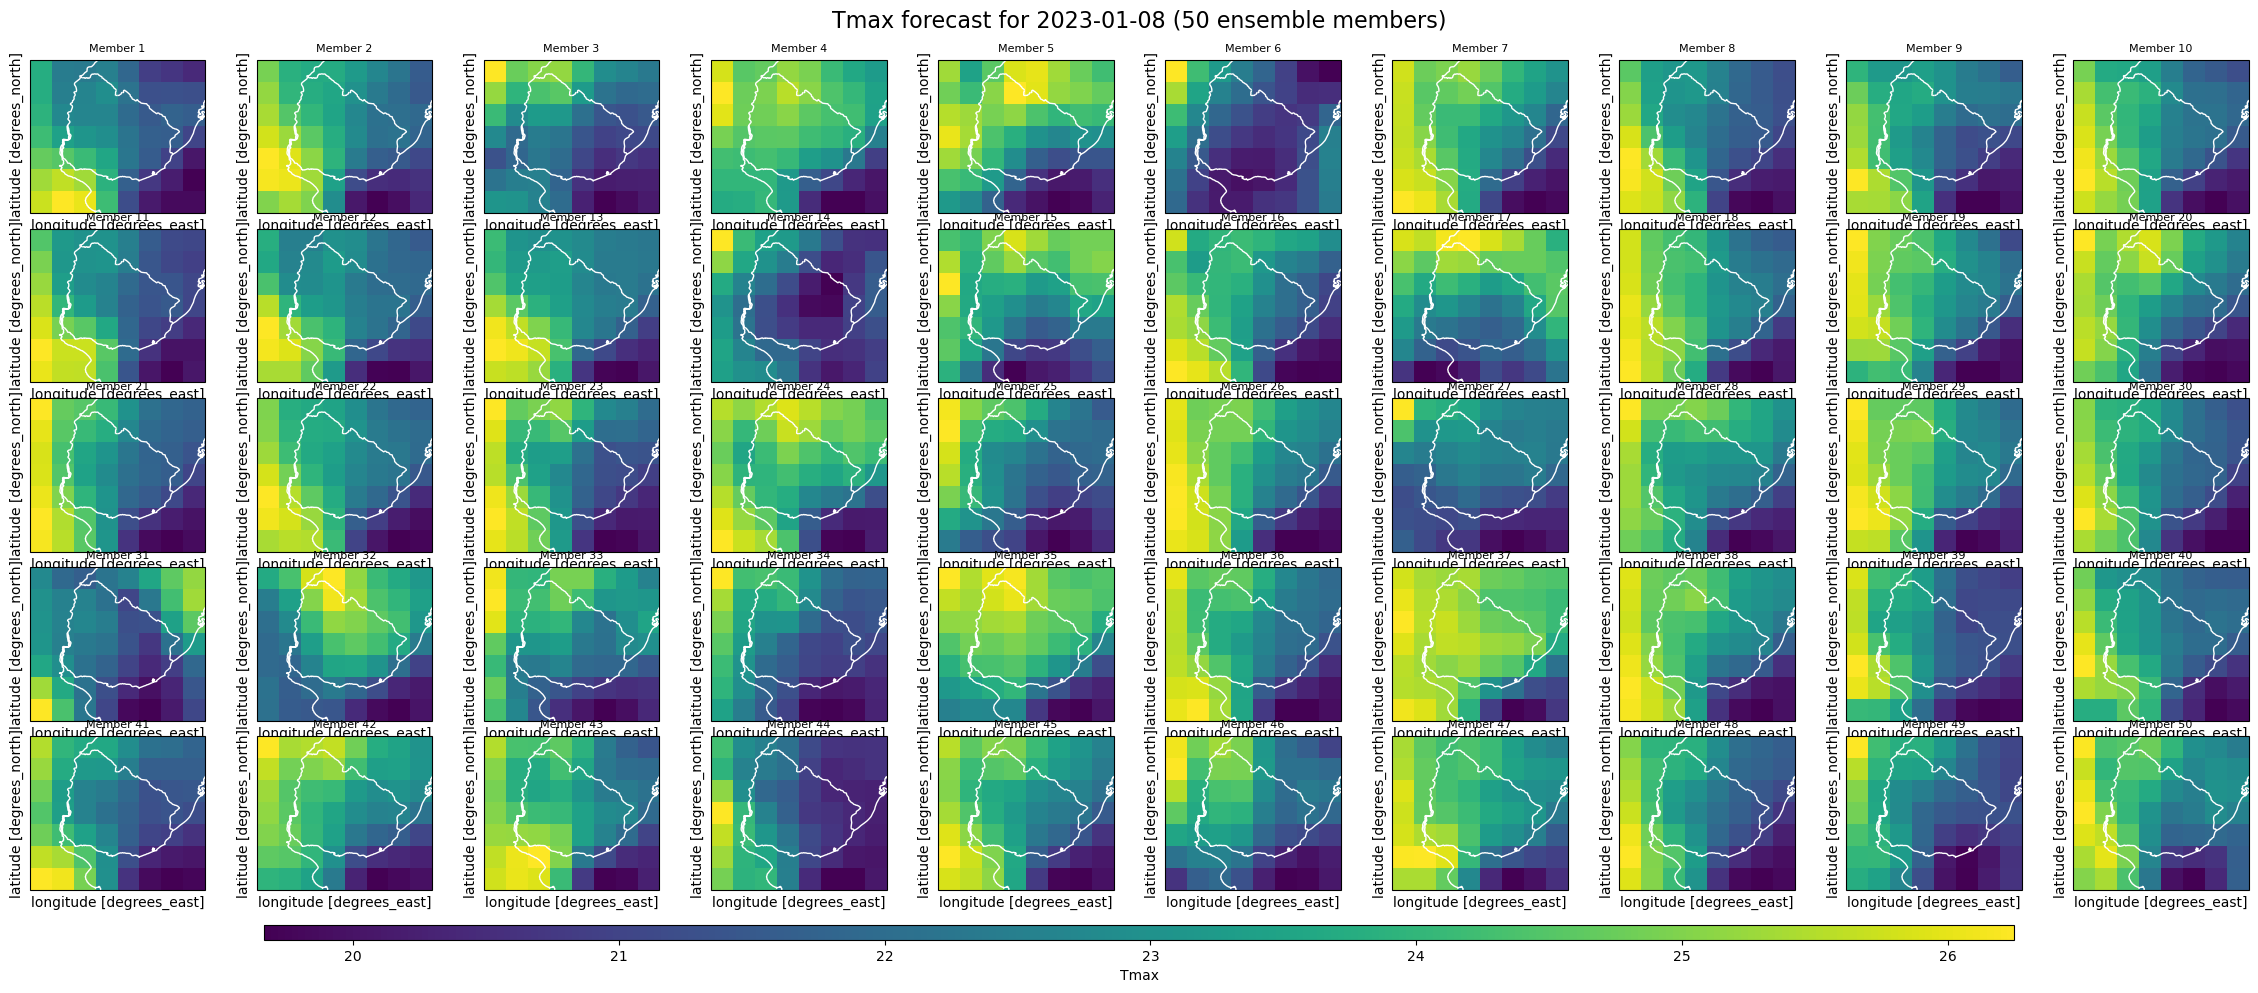

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot all the member for one day
target_date = "2023-01-08"
index_metric = "Tmax"

init_time = pd.to_datetime(ds_daily["time"].values.item())  # scalar datetime
steps = ds_daily["step"].values  # timedelta64[ns]

forecast_dates = init_time + pd.to_timedelta(steps)  # Compute real forecast dates

target_datetime = pd.to_datetime(
    target_date
)  # Find matching step index for target date
index_match = np.where(forecast_dates.normalize() == target_datetime.normalize())[0]

if len(index_match) == 0:
    raise ValueError(
        f"Date {target_date} not found in forecast data.\nAvailable dates: {forecast_dates.strftime('%Y-%m-%d').tolist()}"
    )
step_index = index_match[0]

data = ds_daily[index_metric].isel(step=step_index)

fig, axs = plt.subplots(
    5, 10, figsize=(25, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)
axs = axs.flatten()

for i in range(50):
    ax = axs[i]
    p = data.isel(number=i).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        x="longitude",
        y="latitude",
        add_colorbar=False,
        cmap="viridis",
    )
    ax.coastlines(color="white")
    ax.add_feature(cfeature.BORDERS, edgecolor="white")
    ax.set_title(f"Member {i+1}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(
    bottom=0.1, top=0.93, left=0.05, right=0.95, wspace=0.1, hspace=0.1
)  # Add shared colorbar
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.015])
fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label=index_metric)
plt.suptitle(
    f"{index_metric} forecast for {target_date} (50 ensemble members)", fontsize=16
)
plt.show()

We can also access the monthly index data, where the `step` coordinate now represents **monthly values** instead of daily ones, reflecting the aggregation over each forecast month.

In [10]:
import datetime

ds_monthly = xr.open_dataset(
    "/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/indices/Tmax/Tmax_boundsN-59_S-35_E-52_W-29_monthly.nc"
)
for step in ds_monthly.step.values:
    print(str(step))

2022-12
2023-01
2023-02


You can now also explore ensemble statistics over time using the precomputed `stats.nc` file. The file contains ten statistical variables: mean, median, max, min, standard deviation, and percentiles from p5 to p95, computed across ensemble members. These stored variables allow for easy plotting and visualization of how ensemble members vary across forecast months. As expected, the spread in member predictions tends to increase toward the end of the forecast period.


In [11]:
# Call the statistics file
ds_stats = xr.open_dataset(
    "/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/indices/Tmax/Tmax_boundsN-59_S-35_E-52_W-29_stats.nc"
)
ds_stats

<xarray.Dataset> Size: 10kB
Dimensions:          (latitude: 7, longitude: 8, step: 3)
Coordinates:
    time             datetime64[ns] 8B ...
    surface          float64 8B ...
  * latitude         (latitude) float64 56B -29.95 -30.95 ... -34.95 -35.95
  * longitude        (longitude) float64 64B -59.43 -58.43 ... -53.43 -52.43
  * step             (step) <U7 84B '2022-12' '2023-01' '2023-02'
    quantile         float64 8B ...
Data variables:
    ensemble_mean    (step, latitude, longitude) float32 672B ...
    ensemble_median  (step, latitude, longitude) float32 672B ...
    ensemble_max     (step, latitude, longitude) float32 672B ...
    ensemble_min     (step, latitude, longitude) float32 672B ...
    ensemble_std     (step, latitude, longitude) float32 672B ...
    ensemble_p5      (step, latitude, longitude) float64 1kB ...
    ensemble_p25     (step, latitude, longitude) float64 1kB ...
    ensemble_p50     (step, latitude, longitude) float64 1kB ...
    ensemble_p75     (step, latitude, longitude) float64 1kB ...
    ensemble_p95     (step, latitude, longitude) float64 1kB ...

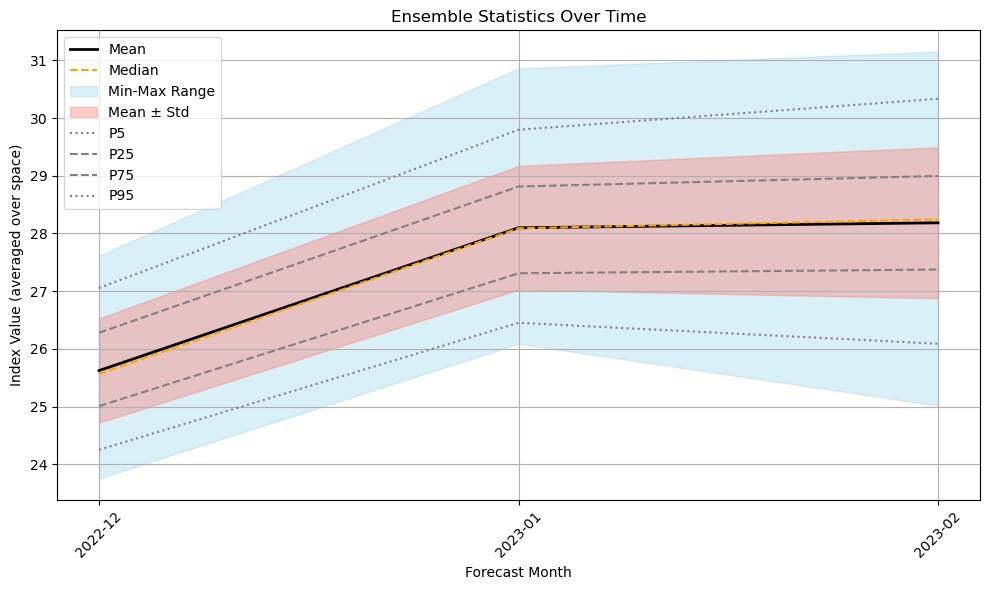

In [12]:
# Extract statistics
steps = ds_stats["step"].values
mean = ds_stats["ensemble_mean"].mean(dim=["latitude", "longitude"])
median = ds_stats["ensemble_median"].mean(dim=["latitude", "longitude"])
std = ds_stats["ensemble_std"].mean(dim=["latitude", "longitude"])
min_ = ds_stats["ensemble_min"].mean(dim=["latitude", "longitude"])
max_ = ds_stats["ensemble_max"].mean(dim=["latitude", "longitude"])
p5 = ds_stats["ensemble_p5"].mean(dim=["latitude", "longitude"])
p25 = ds_stats["ensemble_p25"].mean(dim=["latitude", "longitude"])
p75 = ds_stats["ensemble_p75"].mean(dim=["latitude", "longitude"])
p95 = ds_stats["ensemble_p95"].mean(dim=["latitude", "longitude"])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, mean, label="Mean", color="black", linewidth=2)
plt.plot(steps, median, label="Median", color="orange", linestyle="--")
plt.fill_between(steps, min_, max_, color="skyblue", alpha=0.3, label="Min-Max Range")
plt.fill_between(
    steps, mean - std, mean + std, color="salmon", alpha=0.4, label="Mean ± Std"
)
plt.plot(steps, p5, label="P5", linestyle=":", color="gray")
plt.plot(steps, p25, label="P25", linestyle="--", color="gray")
plt.plot(steps, p75, label="P75", linestyle="--", color="gray")
plt.plot(steps, p95, label="P95", linestyle=":", color="gray")
plt.title("Ensemble Statistics Over Time")
plt.xlabel("Forecast Month")
plt.ylabel("Index Value (averaged over space)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Calculate a Hazard Object

Then you can call `forecast.process_and_save_hazards` method to convert processed index from Copernicus forecast data into a hazard object.

- **Hazard Object Creation**: The method processes seasonal forecast data for specified years and months, converting these into hazard objects. These objects encapsulate potential risks associated with specific weather events or conditions, such as Maximum Temperature ('Tmax') indicated in the parameters, over the forecast period.

- **Data Storage**: The hazard data for each ensemble member of the forecast is saved as HDF5 files. These files are automatically stored in specific directories corresponding to each month and type of hazard. The file paths are printed below the processing steps. For example, *"/SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5"*.
 HDF5 is a versatile data model that efficiently stores large volumes of complex data.
 
 Each file is specific to a particular month and hazard scenario ('Tmax' in this case) and covers all ensemble members for that forecast period, aiding in detailed risk analysis.

- **Completeness of Data Processing**: Messages like 'Completed processing for 2022-07. Data saved in...' confirm the successful processing and storage of the hazard data for that period, ensuring that all requested data has been properly handled and stored.

In [13]:
from climada.hazard import Hazard

forecast.save_index_to_hazard()

{'2022_init11_valid12_02': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init11/valid12_02/hazard/Tmax/Tmax_boundsN-59_S-35_E-52_W-29.hdf5')}

You can always inspect the properties of the `Hazard` object or visualize its contents. Noted the `date` attribute uses **serial date numbers** (ordinal format), which is common in climate data. To convert these to standard datetime format, you can use datetime.datetime.fromordinal. 

In [14]:
# Load the hazard and plot intensity for the selected grid
forecast.save_index_to_hazard()
initiation_month_str = f"{month_name_to_number(initiation_month[0]):02d}"
forecast_month_str = f"{forecast.valid_period_str[-2:]}"  # Last month in valid period
forecast_year = year_list[0]

path_to_hazard = forecast.get_pipeline_path(
    forecast_year, initiation_month_str, "hazard"
)
hazard = Hazard.from_hdf5(path_to_hazard)

# Access hazard attributes
print("Hazard attributes:")
print(" - Shape of intensity (time, gridpoint):", hazard.intensity.shape)
print(" - Centroids:", hazard.centroids.shape)
print(" - Units:", hazard.units)
print(" - event_id:", hazard.event_id)
print(" - frequency:", hazard.frequency)
print(" - min, max fraction:", hazard.fraction.min(), hazard.fraction.max())
print(" - Date:", hazard.date)
print("min, max fraction: ", hazard.fraction.min(), hazard.fraction.max())
print(" - event_name:"), hazard.event_name

Hazard attributes:
 - Shape of intensity (time, gridpoint): (150, 56)
 - Centroids: (7, 8)
 - Units: °C
 - event_id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150]
 - frequency: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

(None,
 ['member0',
  'member0',
  'member0',
  'member1',
  'member1',
  'member1',
  'member2',
  'member2',
  'member2',
  'member3',
  'member3',
  'member3',
  'member4',
  'member4',
  'member4',
  'member5',
  'member5',
  'member5',
  'member6',
  'member6',
  'member6',
  'member7',
  'member7',
  'member7',
  'member8',
  'member8',
  'member8',
  'member9',
  'member9',
  'member9',
  'member10',
  'member10',
  'member10',
  'member11',
  'member11',
  'member11',
  'member12',
  'member12',
  'member12',
  'member13',
  'member13',
  'member13',
  'member14',
  'member14',
  'member14',
  'member15',
  'member15',
  'member15',
  'member16',
  'member16',
  'member16',
  'member17',
  'member17',
  'member17',
  'member18',
  'member18',
  'member18',
  'member19',
  'member19',
  'member19',
  'member20',
  'member20',
  'member20',
  'member21',
  'member21',
  'member21',
  'member22',
  'member22',
  'member22',
  'member23',
  'member23',
  'member23',
  'member24',
 

Available Dates Across Members: ['2022-12-01', '2023-01-01', '2023-02-01']
Selected Date for Plotting: 2023-02-01


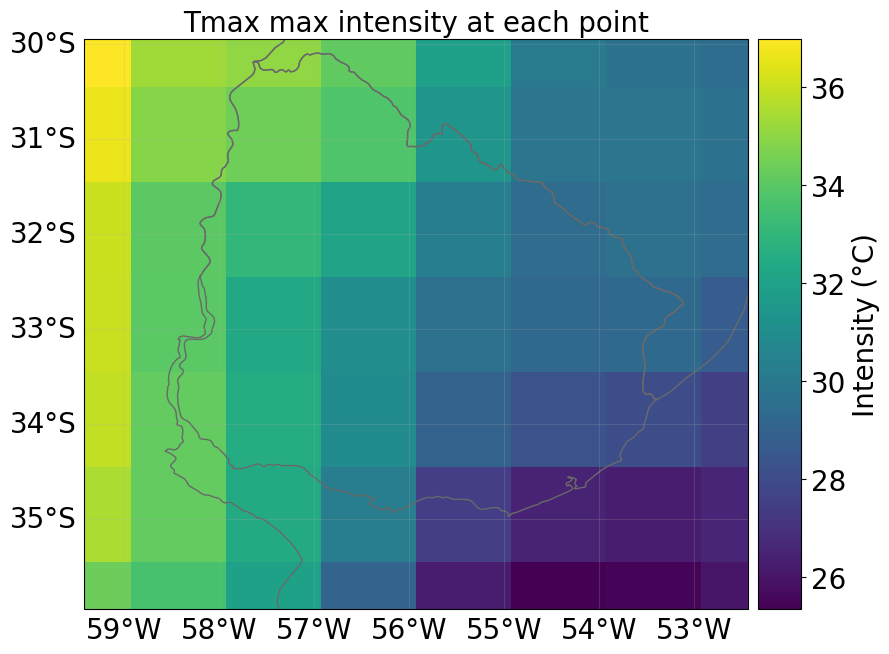

In [15]:
# load an example hazard
initiation_year = year_list[0]
initiation_month_str = f"{month_name_to_number(initiation_month[0]):02d}"

forecast_month = int(forecast.valid_period_str[-2:])
forecast_year = (
    initiation_year + 1
    if int(initiation_month_str) > forecast_month
    else initiation_year
)

path_to_hazard = forecast.get_pipeline_path(
    initiation_year, initiation_month_str, "hazard"
)
haz = Hazard.from_hdf5(path_to_hazard)

if haz:
    available_dates = sorted(set(haz.date))
    readable_dates = [
        dt.datetime.fromordinal(d).strftime("%Y-%m-%d") for d in available_dates
    ]
    print("Available Dates Across Members:", readable_dates)

    target_date = dt.datetime(
        forecast_year, forecast_month, 1
    ).toordinal()  # Look for the first day of the last forecast month
    closest_date = min(available_dates, key=lambda x: abs(x - target_date))
    closest_date_str = dt.datetime.fromordinal(closest_date).strftime("%Y-%m-%d")

    print(f"Selected Date for Plotting: {closest_date_str}")
    haz.select(date=[closest_date, closest_date]).plot_intensity(event=0, smooth=False)

else:
    print("No hazard data found for the selected period.")

Now you have a `Hazard` object that you can use in your specific impact assessment. In addition, you also have access to daily and monthly index estimates, along with ensemble statistics. Of course, the original hourly data of the climate variables related to your index of interest is also available, including their daily statistics.

If you would like to explore more advanced examples, please visit the package repository. There, you will find additional Python notebooks as well as links to plug-and-play Google Colab notebooks demonstrating the full capabilities of the package.


## **Resources**

- [Copernicus Seasonal Forecast Tools package](https://github.com/DahyannAraya/copernicus-seasonal-forecast-toolsb)

- [Copernicus Seasonal Forecast Tools documentation](https://copernicus-seasonal-forecast-tools.readthedocs.io/en/latest/?badge=latest)

- [Copernicus Seasonal Forecast Tools demo](https://colab.research.google.com/github/DahyannAraya/copernicus_climada_seasonal_forecast_workshop/blob/main/Modul_climada_copernicus_seasonal_forecast_workshop.ipynb#scrollTo=Download_and_Process_Data)

- [Copernicus Seasonal Forecast Tools extended demostration](https://colab.research.google.com/github/DahyannAraya/climada_copernicus_seasonal_forecast_workshop/blob/main/DEMO_Modul_climada_copernicus_seasonal_forecast_workshop.ipynb)


Additional resources:
- [U-CLIMADAPT Project](https://www.copernicus-user-uptake.eu/user-uptake/details/responding-to-the-impact-of-climate-change-u-climadapt-488)

- [Seasonal forecast daily and subdaily data on single levels](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview)

- [Copernicus Climate Data Store](https://cds.climate.copernicus.eu)

- [CLIMADA Documentation](https://climada.ethz.ch/)